## <center> Airlines Customer Satisfaction (Classification) - CatBoost and SHAP </center> 
<center> Denver Magtibay---Tae Hwan Kim---Mahmoud Besaiso </center> 

In [1]:
!pip install catboost
!pip install --upgrade torch torchvision torchaudio
!pip install shap
!pip install --upgrade matplotlib catboost

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

# Import classifier
from catboost import CatBoostClassifier as CBC

import warnings
warnings.filterwarnings('ignore') # Suppress warnings

In [3]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

#### Loading Data

In [4]:
airlineDF = pd.read_csv("SPJAIN_Airline.csv")

**About this Dataset**

This dataset is provided by an airline organization known as SPJAIN airlines, although the actual company name is not disclosed for privacy reasons.

It contains information about customers who have previously traveled with the airline. The dataset includes feedback from customers on different aspects and their flight-related data.

The primary objective of this dataset is to forecast whether future customers will be content with the airline's service based on various parameter values.

Additionally, the airline aims to identify areas of their services that require more attention to increase customer satisfaction.

In [5]:
airlineDF.shape

(129880, 23)

In [6]:
side_by_side(airlineDF.isnull().sum(), airlineDF.count()) # out of total rows how many rows of them are Null

satisfaction                           0    satisfaction                         129880
Gender                                 0    Gender                               129880
Customer Type                          0    Customer Type                        129880
Age                                    0    Age                                  129880
Type of Travel                         0    Type of Travel                       129880
Class                                  0    Class                                129880
Flight Distance                        0    Flight Distance                      129880
Seat comfort                           0    Seat comfort                         129880
Departure/Arrival time convenient      0    Departure/Arrival time convenient    129880
Food and drink                         0    Food and drink                       129880
Gate location                          0    Gate location                        129880
Inflight wifi service           

In [7]:
airlineDF[['Class']].groupby(['Class']).size()

Class
Business    62160
Eco         58309
Eco Plus     9411
dtype: int64

#### Label Encoding 

In [8]:
# Mapping for 'satisfaction' column - label encoding
satisfaction_mapping = {"satisfied": 1, "dissatisfied": 0}
# Apply label encoding to 'satisfaction' column
airlineDF['satisfaction'] = airlineDF['satisfaction'].map(satisfaction_mapping)

# Mapping for 'Gender' column - label encoding
gender_mapping = {"Female": 1, "Male": 0}
# Apply label encoding to 'Gender' column
airlineDF['Gender'] = airlineDF['Gender'].map(gender_mapping)

# Mapping for 'Customer Type' column - label encoding
customer_type_mapping = {"Loyal Customer": 1, "disloyal Customer": 0}
# Apply label encoding to 'Customer Type' column
airlineDF['Customer Type'] = airlineDF['Customer Type'].map(customer_type_mapping)

# Mapping for 'Type of Travel' column - label encoding
travel_type_mapping = {"Business travel": 2, "Personal Travel": 1}
# Apply label encoding to 'Type of Travel' column
airlineDF['Type of Travel'] = airlineDF['Type of Travel'].map(travel_type_mapping)

# Mapping for 'Class' column - label encoding
class_mapping = {"Business": 3, "Eco Plus": 2, "Eco": 1}
# Apply label encoding to 'Class' column
airlineDF['Class'] = airlineDF['Class'].map(class_mapping)

#### Catigorical Features 

In [9]:
airlineDF.nunique() ## how many unique values does each feature have? 

satisfaction                            2
Gender                                  2
Customer Type                           2
Age                                    75
Type of Travel                          2
Class                                   3
Flight Distance                      5398
Seat comfort                            6
Departure/Arrival time convenient       6
Food and drink                          6
Gate location                           6
Inflight wifi service                   6
Inflight entertainment                  6
Online support                          6
Ease of Online booking                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Cleanliness                             6
Online boarding                         6
Departure Delay in Minutes            466
Arrival Delay in Minutes              472
dtype: int64

In [10]:
airlineDF.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

In [11]:
cat_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort',
               'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
               'Inflight wifi service', 'Inflight entertainment', 'Online support',
               'Ease of Online booking', 'On-board service', 'Leg room service',
               'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

target = 'satisfaction'

#### Check Class Balance 

Counts of each class:
satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64


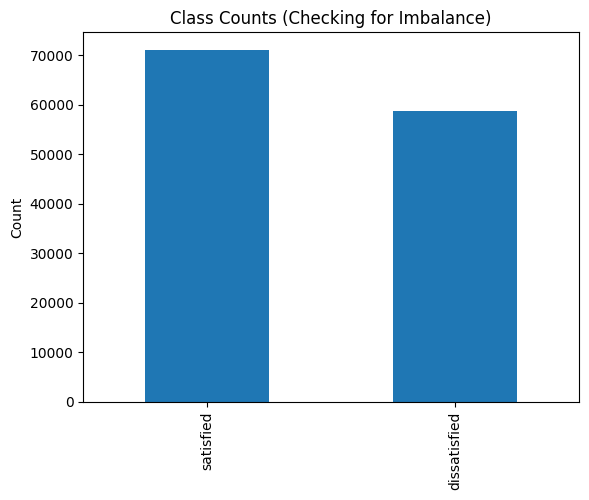

DataFrame shape: (129880, 23)


In [12]:
# Map class labels for better readability
class_mapping = {1: "satisfied", 0: "dissatisfied"}
airlineDF[target] = airlineDF[target].map(class_mapping)

# Print counts of each class
print("Counts of each class:")
class_counts = airlineDF[target].value_counts()
print(class_counts)

# Plot counts of each class
class_counts.plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
plt.show()  # Ensure the plot is displayed

# Display the shape of the DataFrame
print("DataFrame shape:", airlineDF.shape)


The dataset is little bit imbalanced, with a majority of instances classified as "satisfied" (71,087) and a minority as "dissatisfied" (58,793). Imbalanced datasets can pose challenges for machine learning models and require special consideration during model training and evaluation.

#### Missing Value Handling 

CatBoost was selected for its ability to handle datasets with missing values, streamlining the preprocessing step and allowing for direct modeling without the need for imputation or removal of missing data.

In [13]:
# Calculate percentage of missing values in the 'Arrival Delay in Minutes' column
missing_percentage = airlineDF['Arrival Delay in Minutes'].isnull().sum() / airlineDF.shape[0] * 100

# Print the percentage of missing values with 3 decimal places
print("Percentage of missing: {} %".format(round(missing_percentage, 3)))

Percentage of missing: 0.303 %


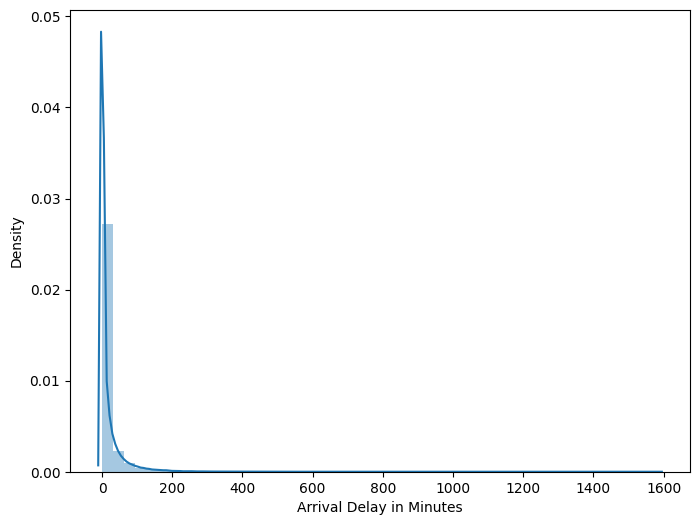

In [14]:
# Visualize the distribution of 'Arrival Delay in Minutes' feature
fig = plt.figure(figsize=(8, 6))

# Plot a distribution plot (histogram) for the 'Arrival Delay in Minutes' feature
sns.distplot(airlineDF['Arrival Delay in Minutes'])

# Show the plot
plt.show()

Given the presence of missing values and numerous outliers in the "Arrival Delay in Minutes" column, the decision has been made to exclude this column from the dataset. 

#### Splitting dataset into train, validation and test 

In [15]:
X = airlineDF.drop([target, 'Arrival Delay in Minutes'], axis=1)
y = airlineDF[target]

In [16]:
SEED = 42 
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED) 

In [17]:
SEED = 42 
VAL_SIZE = 0.2 # % of train data

X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=SEED)  

#### Baseline model: catboost

In [18]:
from catboost import CatBoostClassifier as CBC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define the CatBoostClassifier model with specified parameters
model = CBC(
    iterations=50,  # Number of boosting iterations
    random_seed=42,  # Random seed for reproducibility
    learning_rate=0.1,  # Learning rate for gradient boosting
    custom_loss=['Accuracy'],  # Custom loss function for training
    eval_metric='Accuracy'  # Evaluation metric to monitor during training
)

# Fit the model to the training data and evaluate on the validation data
model.fit(
    X_train, y_train,  # Training data
    cat_features=cat_features,  # Categorical features
    eval_set=(X_val, y_val),  # Validation data
    logging_level='Silent',  # Set logging level to Silent
    plot=True  # Plot training progress (optional)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Evaluation on test dataset 

In [31]:
# Predict on the test data
y_pred_test = model.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, pos_label='satisfied')
recall_test = recall_score(y_test, y_pred_test, pos_label='satisfied')
f1_test = f1_score(y_test, y_pred_test, pos_label='satisfied')
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Print evaluation metrics
print("Test Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)
print("AUC-ROC Score:", roc_auc_test)
print("Confusion Matrix:")
print(conf_matrix_test)

Test Accuracy: 0.931706190329535
Precision: 0.9307623069999308
Recall: 0.9455581346275586
F1 Score: 0.9381018841591068
AUC-ROC Score: 0.985606693016951
Confusion Matrix:
[[10759  1000]
 [  774 13443]]


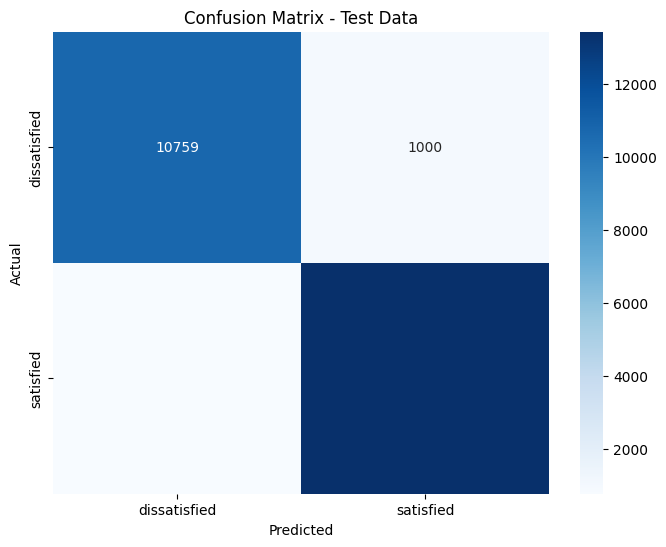

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['dissatisfied', 'satisfied'], 
            yticklabels=['dissatisfied', 'satisfied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

With basic hyperparameters we can get high result of 93.17%

#### Explainability with Shap 

> Using the SHAP (SHapley Additive exPlanations) library, we can gain insights into the impact of different features on the accuracy of our model. SHAP values provide a way to interpret the output of machine learning models by quantifying the contribution of each feature to the predicted outcome.

In [23]:
import shap

In [24]:
# Create a SHAP TreeExplainer object for the CatBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Get the base value (expected value) from the explainer
base_value = explainer.expected_value

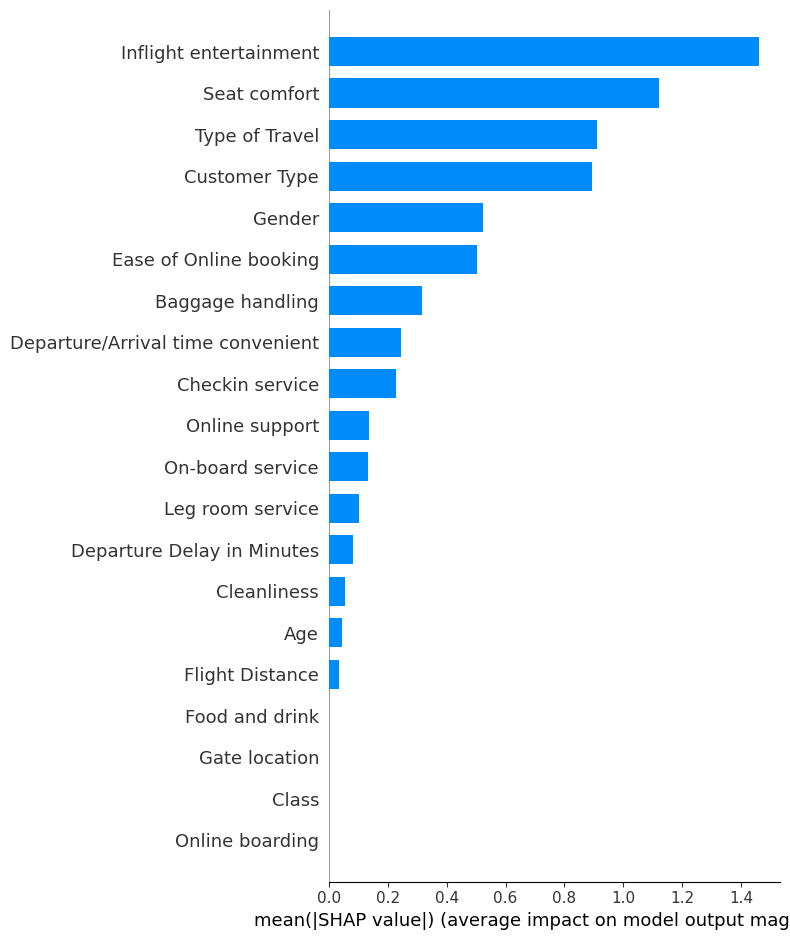

In [25]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

Here we can see that the top 4 features that has the biggest average impact on the result are Inflight entertainment, Seat comfort, Type of Travel and Customer Type.

**Inflight Entertainment**

<Axes: xlabel='Inflight entertainment', ylabel='count'>

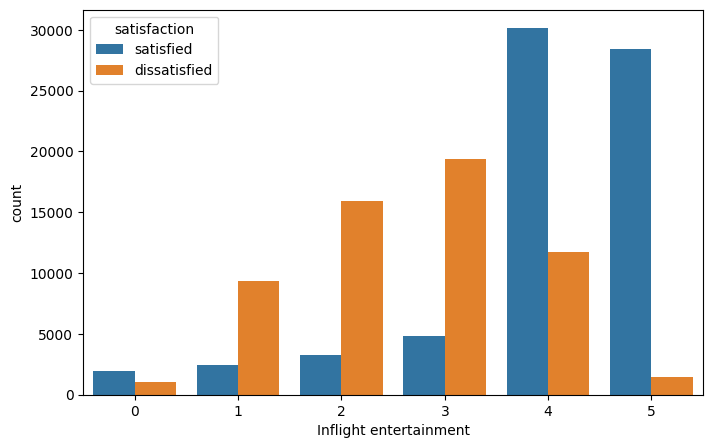

In [26]:
plt.figure(figsize=(8, 5))

x = 'Inflight entertainment'
y = target

sns.countplot(x=x, hue=y, data=airlineDF) 

> Passengers who rate the inflight entertainment as 4 or 5 tend to be mostly satisfied with their overall experience. This suggests that the quality or availability of inflight entertainment significantly contributes to passengers' satisfaction levels. Providing a diverse range of entertainment options or ensuring high-quality inflight entertainment systems may enhance overall satisfaction among passengers.

**Seat Comfort**

<Axes: xlabel='Seat comfort', ylabel='count'>

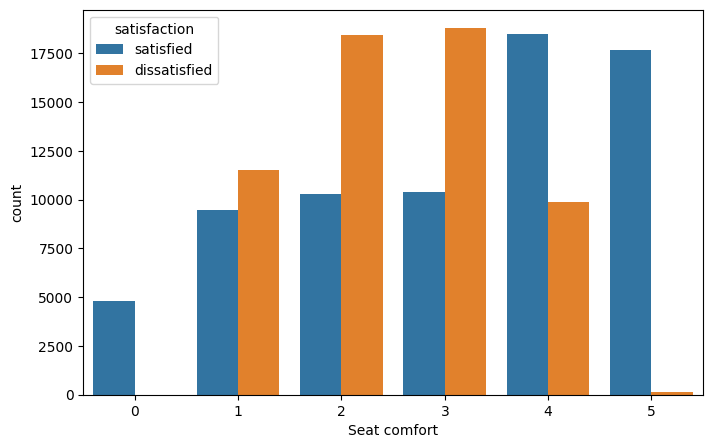

In [27]:
plt.figure(figsize=(8, 5))

x = 'Seat comfort'
y = target

sns.countplot(x=x, hue = y, data = airlineDF) 

> Passengers who rate the seat comfort as 4 or 5 are predominantly satisfied with their overall experience. This implies that the level of comfort provided by the seats significantly influences passengers' satisfaction levels. Ensuring comfortable seating arrangements and amenities may contribute to higher levels of satisfaction among passengers.

**Type of Travel**

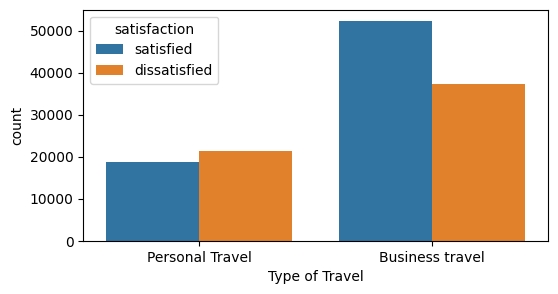

In [28]:
plt.figure(figsize=(6, 3))

# Define the variables for plotting
x = 'Type of Travel'
y = target

# Create a countplot with hue
sns.countplot(x=x, hue=y, data=airlineDF)  

# Set x-axis labels for the ticks
plt.xticks(ticks=[0, 1], labels=["Personal Travel", "Business travel"])

# Show the plot
plt.show()


> Passengers who are traveling for business purposes tend to be more satisfied compared to those traveling for personal reasons. This indicates that the type of travel, whether it is for business or personal purposes, plays a significant role in determining passengers' satisfaction levels. Understanding the specific needs and preferences of passengers based on their travel purposes can help airlines tailor their services to enhance overall satisfaction levels.

**Customer Type**

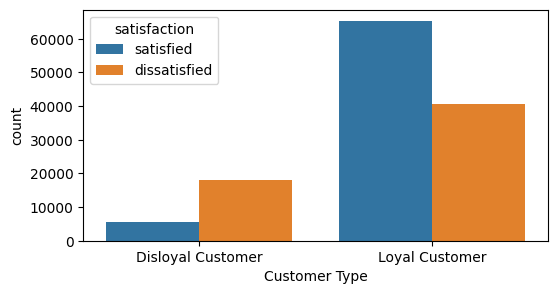

In [29]:
plt.figure(figsize=(6, 3))

# Define the variables for plotting
x = 'Customer Type'
y = target

# Create a countplot with hue
sns.countplot(x=x, hue=y, data=airlineDF)  

# Set x-axis labels for the ticks
plt.xticks(ticks=[1, 0], labels=["Loyal Customer", "Disloyal Customer"])

# Show the plot
plt.show()

> The data shows that loyal customers exhibit higher levels of satisfaction compared to disloyal customers. This suggests that customers who have a history of loyalty to the airline are generally more content with the services provided. Building and maintaining customer loyalty programs or offering exclusive benefits to frequent flyers could be effective strategies to enhance overall customer satisfaction and encourage continued patronage.